# ランダムウォークのシリーズを作成

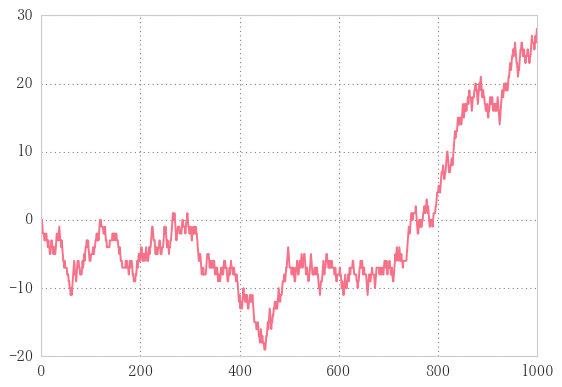

In [2]:
n = 1000
se = pd.Series(np.random.randint(-1, 2, n)).cumsum()
se.plot()

## 前日より値が低かったら買い、高かったら見過ごし

In [14]:
position = np.zeros(len(se))  # seと同じ長さの配列を作成
for i in se.index[:-1]:
    if se[i+1] - se[i] > 0:
        position[i]=se[i]
position

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  -3.,   0.,   0.,
         0.,   0.,   0.,  -4.,   0.,   0.,   0.,   0.,  -5.,  -4.,   0.,
         0.,   0.,   0.,  -5.,   0.,   0.,   0.,  -5.,  -4.,  -3.,   0.,
         0.,   0.,  -3.,  -2.,   0.,   0.,   0.,   0.,  -4.,   0.,   0.,
         0.,   0.,   0.,  -7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0., -11.,   0., -11., -10.,  -9.,  -8.,
        -7.,   0.,   0.,   0.,   0.,  -9.,  -8.,  -7.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,  -8.,  -7.,   0.,  -7.,  -6.,   0.,
        -6.,  -5.,   0.,  -4.,   0.,   0.,  -4.,   0.,   0.,   0.,   0.,
         0.,  -6.,   0.,   0.,   0.,  -5.,   0.,   0.,  -5.,   0.,  -4.,
         0.,  -3.,   0.,   0.,  -3.,   0.,  -3.,  -2.,  -1.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,  -2.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,  -4.,   0.,   0.,   0.,   0.,
        -3.,   0.,   0.,  -3.,   0.,   0.,   0.,  -

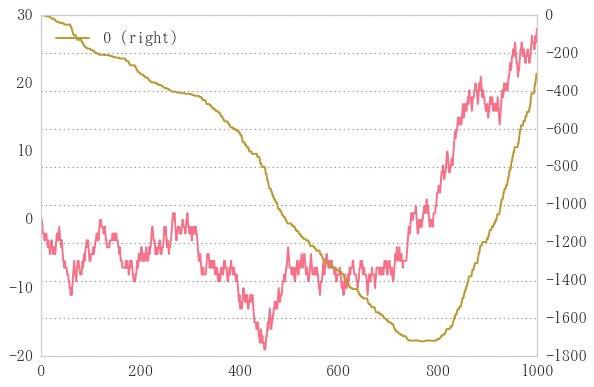

In [23]:
fig, ax = plt.subplots()
se.plot(ax=ax)
pd.DataFrame(position).cumsum().plot(ax=ax, secondary_y=True)  # ポジションのcum sumをプロット
plt.grid(True)

## 特定期間で買い

In [3]:
freq = 5 